# Estimating effect sizes with a DeepDive Model

This tutorial demonstrates how to estimate effect sizes with a **DeepDive** model on single-cell ATAC-seq data.

---

## Imports

In [1]:
import scanpy as sc
import DeepDive
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from utils import reads_to_fragments

## 1. Load and preprocess the dataset
We start with an `AnnData` object containing single-cell chromatin accessibility profiles. Here we use the liver [sciATAC-seq3](https://doi.org/10.1126/science.aba7612) dataset (`sciatac3_liver_10k.h5ad`), subset from the full dataset (dataset and preprocessing better described in the `training.ipynb` notebook).

In [3]:
adata = sc.read_h5ad('data/sciatac3_liver_10k.h5ad')

# Filter genes detected in fewer than 1% of cells
min_cells = int(adata.shape[0] * 0.01)
sc.pp.filter_genes(adata, min_cells=min_cells)

# Ensure unique cell IDs
adata.obs_names_make_unique()

# Convert raw reads into fragments
reads_to_fragments(adata)
adata.X = adata.layers['fragments']

## 2. Define model and training parameters

We specify model hyperparameters and training settings.

In [4]:
n_decoders = 5  
model_params = {
    'n_epochs_pretrain_ae' : 200*n_decoders,
    'n_decoders' : n_decoders,
}
train_params = {
    'max_epoch' : 300*n_decoders, 
    'batch_size' : 1024, 
    'shuffle' : True
}

In [5]:
discrete_covriate_keys = ['sample_name', 'sex', 'batch', 'cell_type']
continuous_covriate_keys = ['day_of_pregnancy']

## 3. Train DeepDive

We initialize and train the model using the training dataset.

In [6]:
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params
                       )

In [7]:
model.train_model(adata, None, 
                  **train_params)

Epoch Train [1500 / 1500]: 100%|██████████| 10/10 [00:00<00:00, 10.10it/s, ETA=01d:00h:21:m41s|01d:00h:21:m41s, kl_loss=1.68, recon_loss=3.15e+3]


## 4. Compare groups

The `DeepDive.compare_groups()` function identifies accessible regions that differ between two groups independent of disentangled covariates.  

In this example, we compare **Hepatoblasts** and **Erythroblasts** to identify differential chromatin accessibility patterns.



In [8]:
da = DeepDive.compare_groups(model, adata, 'cell_type', groupA = 'Hepatoblasts', groupB = 'Erythroblasts')

In [9]:
da.head()

,Feature,groupA,groupB,Difference,Zscore,Pvalue,FDR
0,chr1:565561-565842,0.808578,-1.587507,2.396085,1.704382,0.006697,0.055971
1,chr1:569259-569557,2.841677,1.127797,1.713880,1.223938,0.128054,0.535595
2,chr1:569659-569951,1.822991,-0.457494,2.280485,1.626589,0.011054,0.082341
3,chr1:713647-714744,0.733735,0.902667,-0.168932,-0.094762,0.999939,1.000000
4,chr1:762075-763248,-0.183651,-0.042263,-0.141388,-0.077697,0.999797,1.000000


This returns a DataFrame containing:

- `Difference`: Effect size between the two groups

- `FDR`: False discovery rate (multiple testing–corrected p-value)

We can visualize the differential results as a volcano plot.

Text(0.5, 0, 'Effect size')

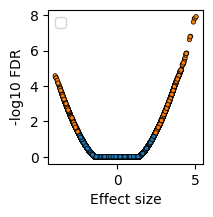

In [10]:
plt.subplots(figsize=(2,2))
sns.scatterplot(
    x=da.Difference, 
    y=-np.log10(da.FDR), 
    hue=da.FDR < 0.05, 
    edgecolor='k', 
    linewidth=0.5, 
    s=10
)
plt.legend([])
plt.ylabel('-log10 FDR')
plt.xlabel('Effect size')

## 5. Compare groups with covariate constraints

DeepDive can also control for confounding factors by fixing certain covariates.
For example, to compare Hepatoblasts vs Erythroblasts while holding sex = female constant:

In [11]:
background = {'sex':'female'}
da = DeepDive.compare_groups(model, adata, 'cell_type', groupA = 'Hepatoblasts', groupB = 'Erythroblasts', background = background)

This performs the same comparison as above but within the context of a fixed background covariate —
allowing interpretation of group differences dependent the **sex**.

## Summary

- `DeepDive.compare_groups()` quantifies differential effects between categorical groups.

- Supports covariate-controlled comparisons via the background argument.

- Returns a feature-level DataFrame with effect sizes and FDR-adjusted p-values.
